In [1]:
from verification_diagrams.verification_diagrams import plot_verification

import xarray as xr 
import numpy as np
import pandas as pd
import sys, os
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython/')

sys.path.append('/home/monte.flora/python_packages/WoF_post')
from monte_python.object_matching import match_to_lsrs, ObjectMatcher
from wofs.verification.lsrs.get_storm_reports import StormReports
from wofs.plotting.util import decompose_file_path
from glob import glob
from os.path import join
import matplotlib

from multiprocessing import Pool
from os.path import dirname, basename
from tqdm import tqdm

from wofs_ml_severe.wofs_ml_severe.common.multiprocessing_utils import run_parallel

In [2]:
base_path = '/work/brian.matilla/WOFS_2021/summary_files/WOFS_ML/'

In [3]:
models = ['RandomForest', 'XGBoost', 'LogisticRegression', 'Baseline']
names = ['RF', 'XGB', 'LR', 'BL' ]
hazards = ['tornado', 'severe_hail', 'severe_wind']
# 'ensemble_tracks'

In [4]:
def to1dfrom2d(preds, labels):
    
    return np.array([np.max(preds[labels==label]) for label in np.unique(labels)[1:]])


def process(path):
    #print(f'{path=}')
    # Load the MLPROB file. 
    ds = xr.load_dataset(path, decode_times=False)
    
    track_file = path.replace('MLPROB', 'ENSEMBLETRACKS')
    
    # Load the track file 
    #print(f'{track_file=}')
    track_ds = xr.load_dataset(track_file, decode_times=False)
    
    # Get the track labels.  
    tracks = ds['ensemble_tracks'].values
    labels = np.unique(tracks)[1:]
    probs = track_ds['w_up__ensemble_probabilities'].values

    # Match reports to the tracks. 
    comps = decompose_file_path(path)
    init_time = comps['VALID_DATE']+comps['VALID_TIME']
    reporter = StormReports(init_time)
    
    storm_data_ds = reporter.to_grid(ds)
    target_vars = [v for v in storm_data_ds.data_vars if 'severe' in v]

    target_obj_match_dict = {}
    
    pred_dict = {}
    for model in models:
        for hazard in hazards: 
            name = f'{model}__{hazard}'
            preds = ds[name].values
            pred_dict[name] = to1dfrom2d(preds, tracks)

    dist = 5
    # May need to iterate over different matching distances 
    for var in target_vars:
        target = storm_data_ds[var].values
        obj_match = ObjectMatcher(min_dist_max=dist,
                                      cent_dist_max=40,
                                      time_max=0,
                                      score_thresh = 0.2,
                                      one_to_one = False, 
                                     match_to_reports=True)

        matched_tracks, _, _ = obj_match.match(object_set_a=tracks, object_set_b=target, input_a=probs)
    
        # Create target column 
        target_obj_match_dict[f"{var}_{dist*3}km_obj_match"] = [1 if label in 
                                                               matched_tracks else 0 for label in labels]
        
    full_data_dict = {**target_obj_match_dict, **pred_dict}
    
    df = pd.DataFrame(full_data_dict)
    run_date = basename(dirname(dirname(paths[0])))
    init_time = comps['INIT_TIME']
    fti = int(comps['TIME_INDEX']) - 6
    
    df['forecast_time_index'] = np.array([fti]*len(df), dtype=np.int8)
    df['Run Date'] = np.array([run_date]*len(df), dtype=object)
    df['Run Time'] = np.array([init_time]*len(df), dtype=object)
    
    return df 

In [25]:
%%time
paths = []
dates = [d for d in os.listdir(join(base_path)) if d[4:6] == '05']
for date in dates:
    init_times = ['2000', '2100', '2200', '2300', '0000', '0100', '0200', '0300']
    for t in init_times:
        files = glob(join(base_path, date, t, 'wofs_MLPROB_*'))
        files.sort()         
        paths.extend(files[12:25])
    

CPU times: user 47.7 ms, sys: 59.7 ms, total: 107 ms
Wall time: 706 ms


In [26]:
results = run_parallel(process, paths, 30)

100%|███████████████████████████████████████████████████████████████████████████████████████| 2262/2262 [03:38<00:00, 10.35it/s]


In [27]:
df = pd.concat(results)

In [28]:
np.unique(df.forecast_time_index)

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
      dtype=int8)

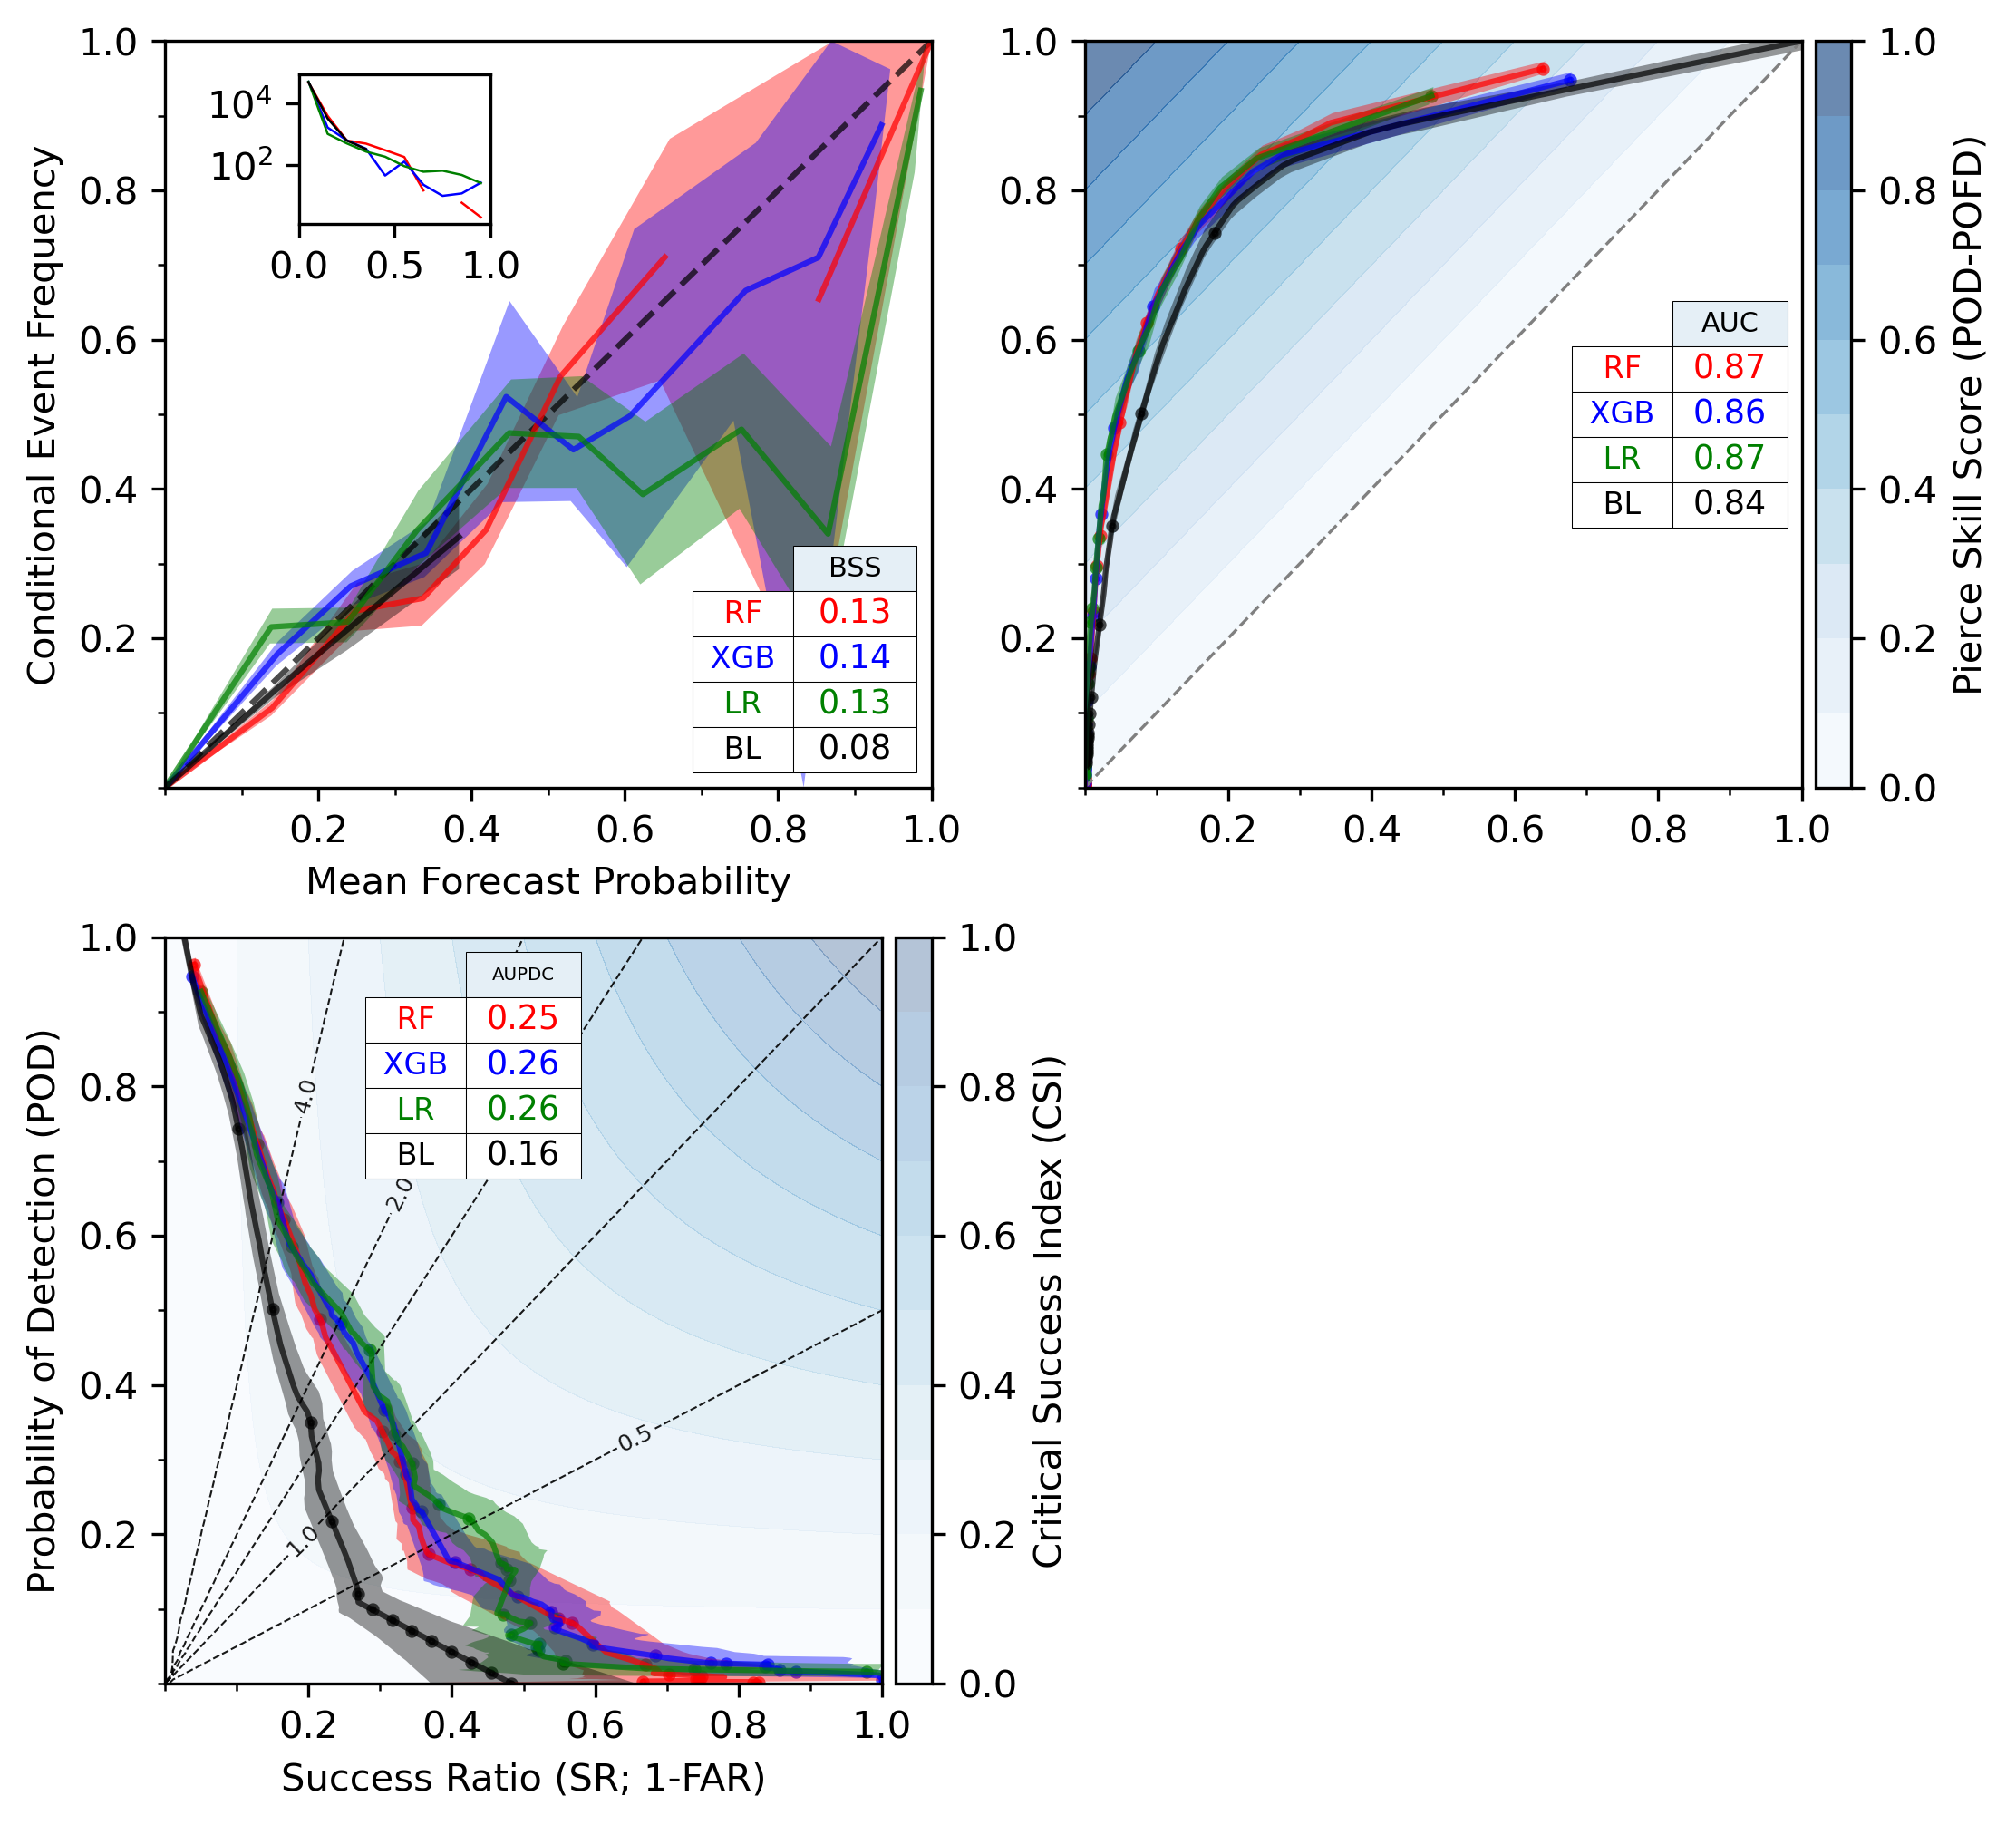

In [29]:
%matplotlib inline

y_test = df['wind_severe_15km_obj_match'].values
y_pred = [df[f'{model}__severe_wind'].values for model in models]
plot_verification(y_test, y_pred, names, n_boot=30)

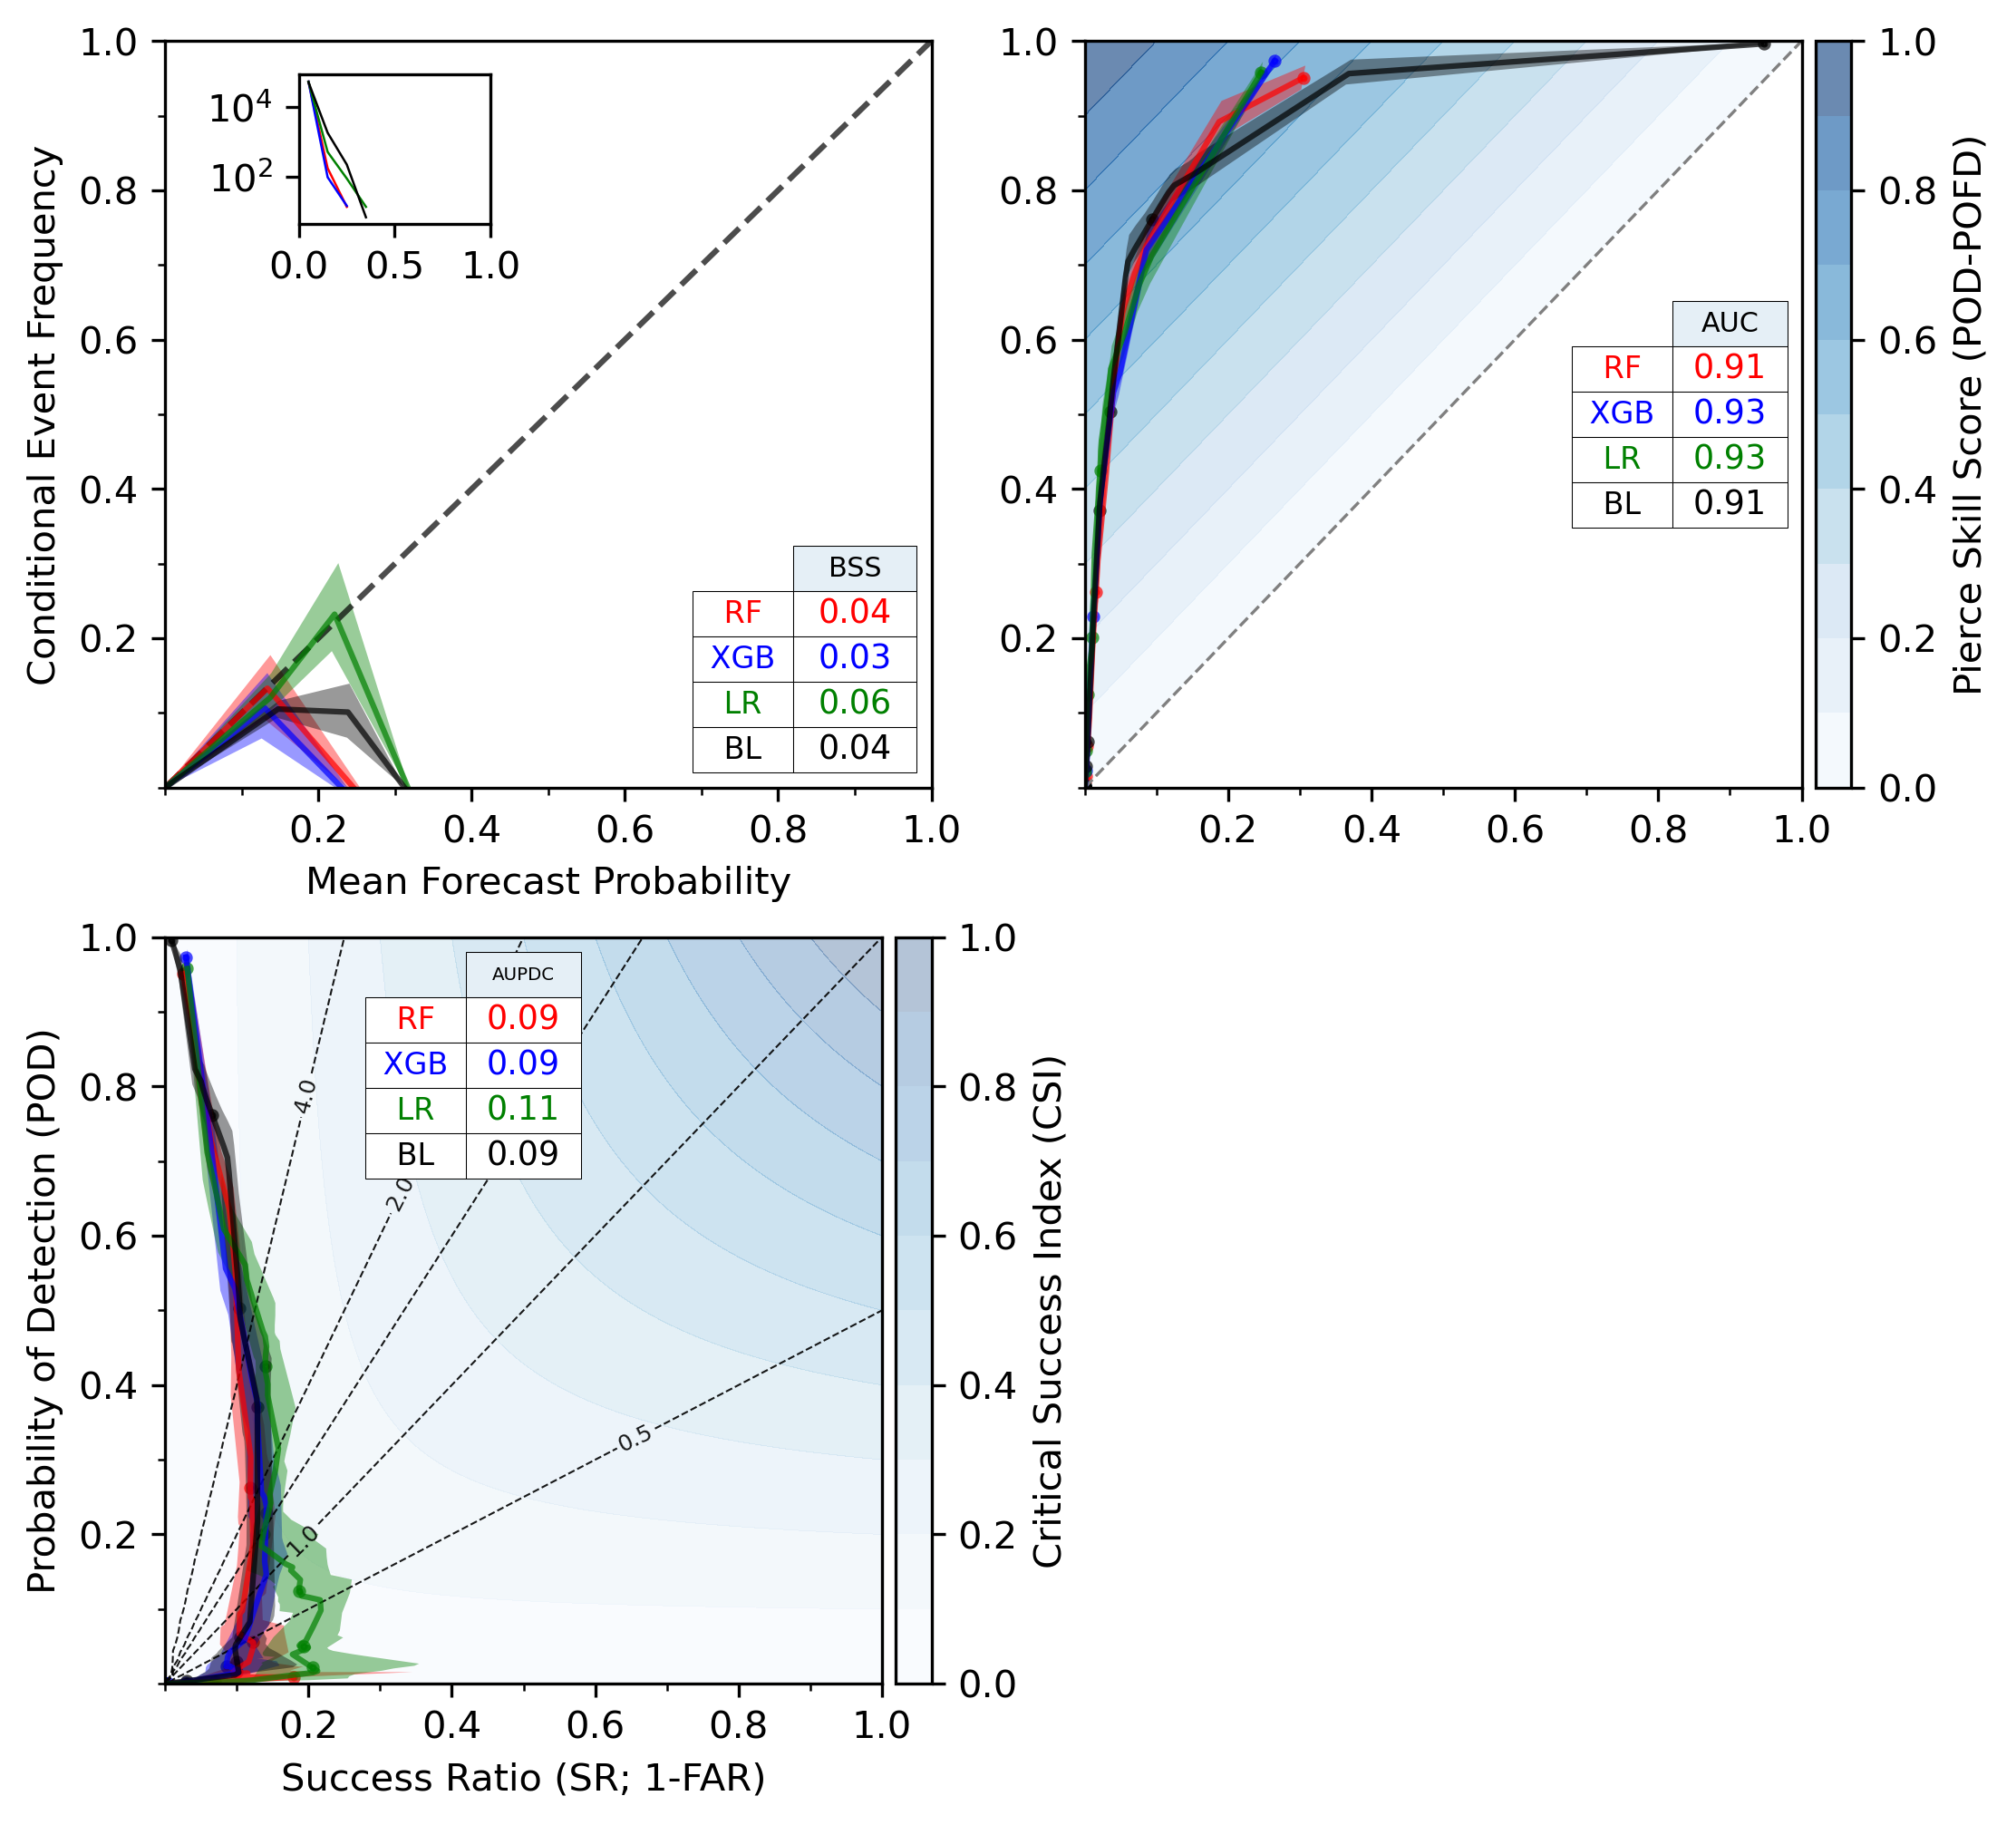

In [30]:
y_test = df['tornado_severe_15km_obj_match'].values
y_pred = [df[f'{model}__tornado'].values for model in models]
plot_verification(y_test, y_pred, names, n_boot=30)

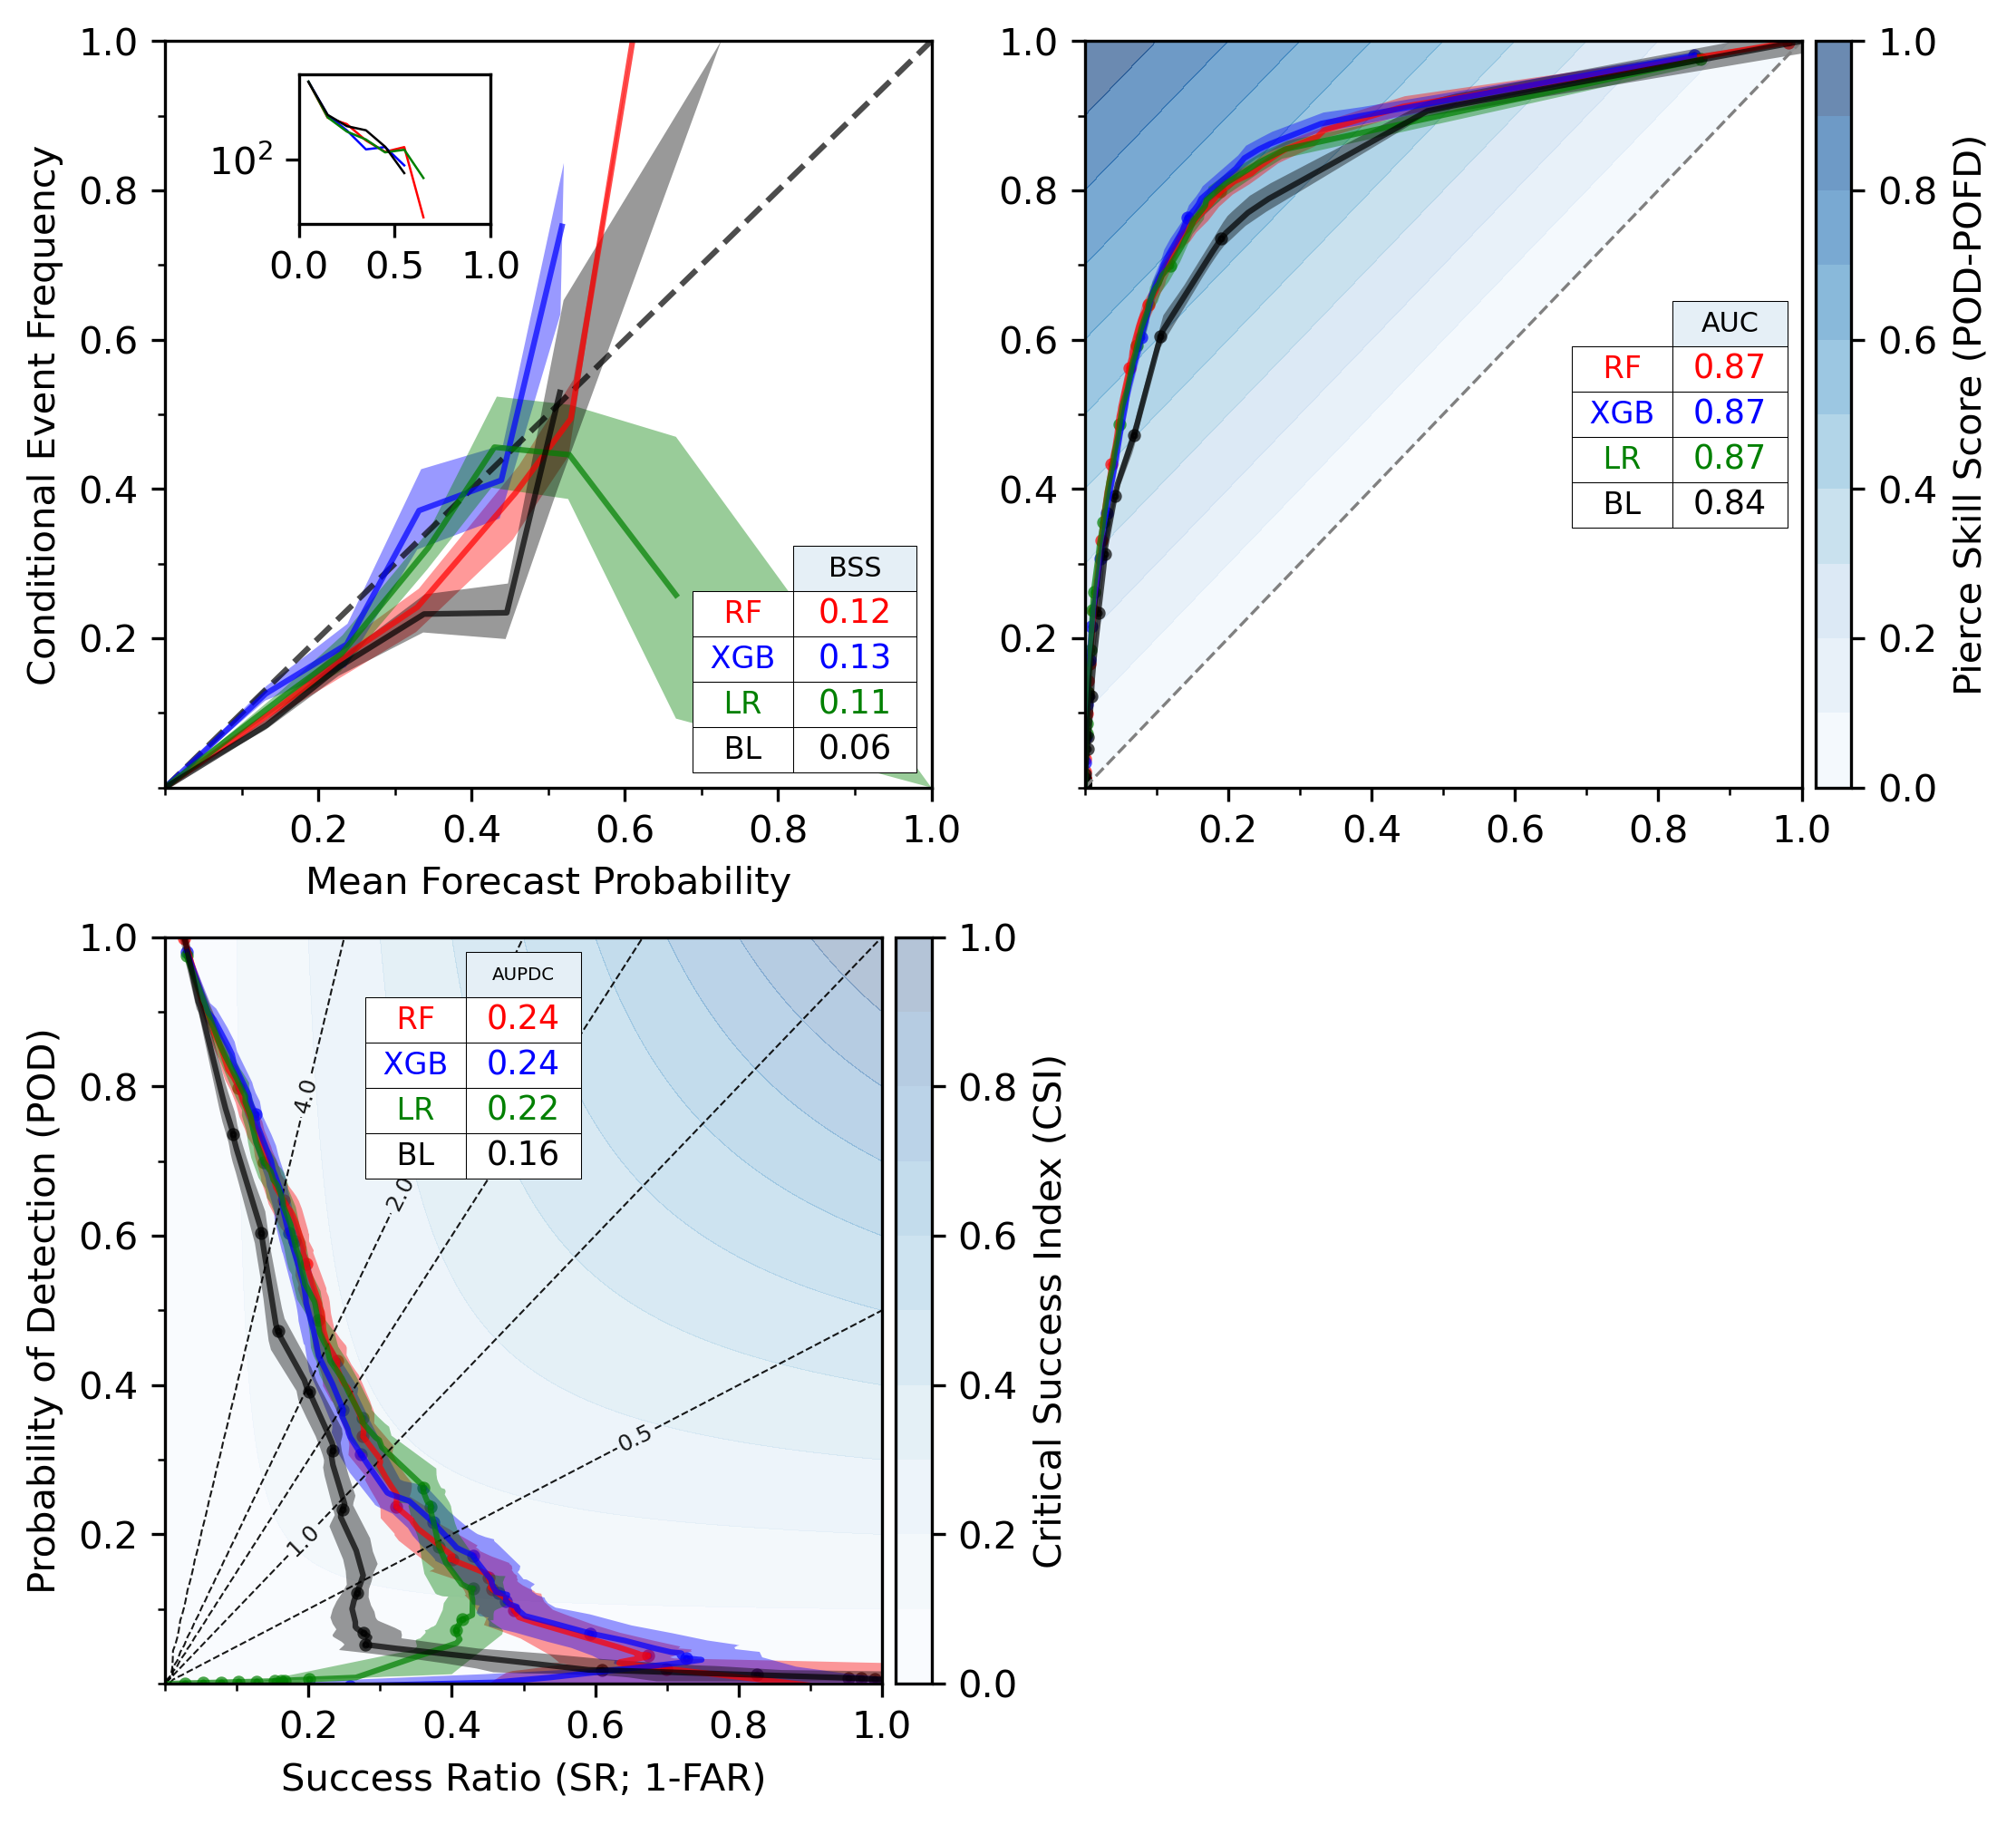

In [31]:
y_test = df['hail_severe_15km_obj_match'].values
y_pred = [df[f'{model}__severe_hail'].values for model in models]
plot_verification(y_test, y_pred, names, n_boot=30)